In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_curve, auc
from neurovlm.data import data_dir, load_masker, load_dataset
from neurovlm.models import load_model
from neurovlm.train import which_device
from neurovlm.metrics import compute_ae_performance

In [2]:
# Load models
device = which_device()
autoencoder = load_model("autoencoder").to(device).eval()
masker = load_masker()

# Load vectors from 01_coordinate.ipynb
neuro_vectors, pmids = torch.load(
    data_dir / "neuro_vectors.pt", weights_only=False,
).values()

train, test, val = torch.load(data_dir / "pmids_split.pt", weights_only=False).values()

In [3]:
# PubMed
X_pubmed = neuro_vectors[pd.Series(pmids).isin(test)].to(device)
with torch.no_grad():
    X_pubmed_re = autoencoder(X_pubmed)
X_pubmed = X_pubmed.to("cpu")
X_pubmed_re = X_pubmed_re.to("cpu")

# Neurovault
nv = torch.load(data_dir / "neurovault.pt", weights_only=False)
df_pubs = nv["df_pubs"]
assert not pd.Series(train).isin(df_pubs["doi"]).any()

X_nv = torch.from_numpy(nv["neuro_clustered"]).to(device)
X_nv = (X_nv > 0).float()
# X_nv = nv["neuro"].to(device)
with torch.no_grad():
    X_nv_re = autoencoder(X_nv)
X_nv = X_nv.to("cpu")
X_nv_re = X_nv_re.to("cpu")

In [4]:
fpr_pm, tpr_pm, pct_pm, roc_auc_pm = compute_ae_performance(X_pubmed, X_pubmed_re)
fpr_nv, tpr_nv, pct_nv, roc_auc_nv = compute_ae_performance(X_nv, X_nv_re)

/home/rph/neurovlm/src/neurovlm/metrics.py:175: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-logits)) # sigmoid(logits)
/home/rph/neurovlm/src/neurovlm/metrics.py:175: RuntimeWarning: overflow encountered in exp
  p = 1 / (1 + np.exp(-logits)) # sigmoid(logits)


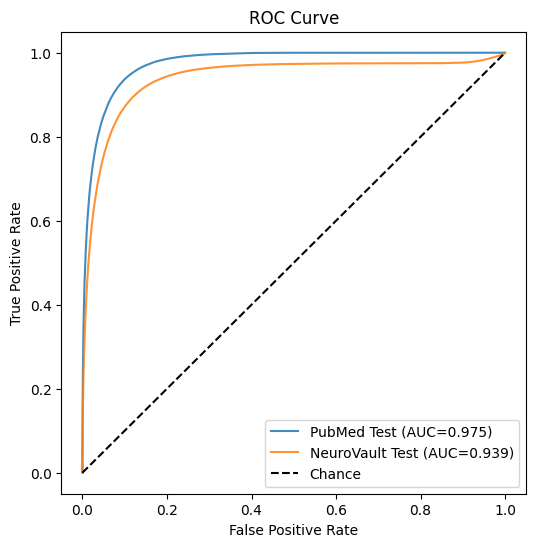

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.plot(fpr_pm[::1000], tpr_pm[::1000], alpha=0.85, label=f"PubMed Test (AUC={roc_auc_pm:.3f})")
ax.plot(fpr_nv[::1000], tpr_nv[::1000], alpha=0.85, label=f"NeuroVault Test (AUC={roc_auc_nv:.3f})")
ax.plot([0, 1], [0, 1], color='k', ls='--', label='Chance')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")
ax.legend()
plt.savefig(data_dir / "autoencoder_perf_a.svg", dpi=300)

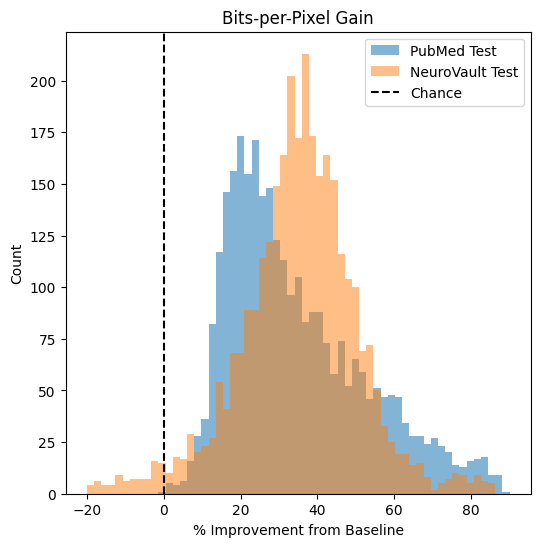

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))

bins = np.linspace(-20, 90, 60)
ax.hist(pct_pm, bins=bins, alpha=0.55, label=f"PubMed Test")
ax.hist(pct_nv, alpha=0.5, bins=bins, label=f"NeuroVault Test")
ax.axvline(0.0, linestyle="--", color='k', label="Chance")
ax.set_xlabel("% Improvement from Baseline")
ax.set_ylabel("Count")
ax.set_title("Bits-per-Pixel Gain")
ax.legend()
plt.savefig(data_dir / "autoencoder_perf_b.svg", dpi=300)

In [11]:
cp ~/.cache/neurovlm/autoencoder_perf_b.svg /mnt/c/Users/ryanp/Desktop/